In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pwd

/content


In [ ]:
import os 
os.chdir('gdrive/My Drive/Colab Notebooks')

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13713279643667790563
 xla_global_id: -1]

In [ ]:
!cat /proc/meminfo

In [ ]:
!pip install pdfplumber
!pip install nltk
!pip install -U gensim
!pip install flask-ngrok
!pip install werkzeug
!pip install numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 40 kB 3.4 MB/s 
     |████████████████████████████████| 3.1 MB 8.0 MB/s 
     |████████████████████████████████| 5.6 MB 34.7 MB/s 
     |████████████████████████████████| 142 kB 34.2 MB/s 
     |████████████████████████████████| 4.0 MB 39.2 MB/s 
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 1.7 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def pdf_extract(file_name):
  import pdfplumber
  directory = "docs"
  pdf_txt = ""
  for file in os.listdir(directory):
      filename = os.fsdecode(file)
      if(filename == file_name):
          pdf_txt = '' # new line
          with pdfplumber.open(directory + '/' + filename) as pdf:
              for pdf_page in pdf.pages:
                single_page_text = pdf_page.extract_text()
                pdf_txt = pdf_txt + single_page_text
  return pdf_txt

In [ ]:
#print(pdf_extract('test.pdf'))

In [ ]:
#New Way pdf Extractor
#!pip install pdf_layout_scanner

In [ ]:
# from pdf_layout_scanner import layout_scanner
# toc=layout_scanner.get_toc('docs/test.pdf')
# pages=layout_scanner.get_pages('docs/test.pdf')
# print(len(pages))

# for i in range(len(pages)):
#     print(pages[i])

In [ ]:
import re
import gensim
from gensim.parsing.preprocessing import remove_stopwords

def clean_sentence(sentence, stopwords=False):
  sentence = sentence.lower().strip()
  sentence = re.sub(r'[^a-z0-9\s]', '', sentence)
  if stopwords:
    sentence = remove_stopwords(sentence)
  return sentence

def get_cleaned_sentences(tokens, stopwords=False):
  cleaned_sentences = []
  for row in tokens:
    cleaned = clean_sentence(row, stopwords)
    cleaned_sentences.append(cleaned)
  return cleaned_sentences

In [ ]:
def retrieveAndPrintFAQAnswer(question_embedding, sentence_embeddings, sentences):
  import sklearn
  from sklearn.metrics.pairwise import cosine_similarity
  max_sim = -1
  index_sim = -1
  for index, embedding in enumerate(sentence_embeddings):
    sim = cosine_similarity(embedding, question_embedding)[0][0]
    if sim > max_sim:
      max_sim = sim
      index_sim = index
  
  return index_sim

In [ ]:
def naive_drive(file_name, question):
  pdf_txt = pdf_extract(file_name)
  import nltk
  import numpy
  import pprint
  nltk.download('punkt')
  tokens = nltk.sent_tokenize(pdf_txt)
  cleaned_sentences = get_cleaned_sentences(tokens, stopwords=True)
  cleaned_sentences_with_stopwords = get_cleaned_sentences(tokens, stopwords=False)
  sentences = cleaned_sentences_with_stopwords
  sentence_words = [[word for word in document.split()]
                    for document in sentences]

  from gensim import corpora
  dictionary = corpora.Dictionary(sentence_words)
  bow_corpus = [dictionary.doc2bow(text) for text in sentence_words]

  question = clean_sentence(question, stopwords=False)
  question_embedding = dictionary.doc2bow(question.split())

  index = retrieveAndPrintFAQAnswer(question_embedding, bow_corpus, sentences)
  return sentences[index]

In [ ]:
# question = "What were the various steps taken by the government to boost domestic and foreign investment in India ?"
# answer = naive_drive('fdi.pdf', question)
# print(answer)

===================================================================================================================

In [ ]:
from gensim.models import Word2Vec
import gensim.downloader as api

v2w_model = None
try:
  v2w_model = gensim.models.Keyedvectors.load('./w2vecmodel.mod')
  print("w2v Model Successfully loaded")
except:
  v2w_model = api.load('word2vec-google-news-300')
  v2w_model.save("./w2vecmodel.mod")
  print("w2v Model Saved")

w2vec_embedding_size = len(v2w_model['pc']) 

[==================================================] 100.0% 1662.8/1662.8MB downloaded
w2v Model Saved


In [ ]:
def getWordVec(word, model):
  import numpy
  samp = model['pc']
  vec = [0]*len(samp)
  try:
    vec = model[word]
  except:
    vec = [0]*len(samp)
  return (vec)


def getPhraseEmbedding(phrase, embeddingmodel):
  import numpy
  samp = getWordVec('computer', embeddingmodel)
  vec = numpy.array([0]*len(samp))
  den = 0;
  for word in phrase.split():
    den = den+1
    vec = vec+numpy.array(getWordVec(word, embeddingmodel))
  return vec.reshape(1, -1)

In [ ]:
def word2vec_drive(file_name, question):
  pdf_txt = pdf_extract(file_name)

  import nltk
  import numpy
  import pprint
  
  nltk.download('punkt')
  tokens = nltk.sent_tokenize(pdf_txt)
  cleaned_sentences = get_cleaned_sentences(tokens, stopwords=True)
  cleaned_sentences_with_stopwords = get_cleaned_sentences(tokens, stopwords=False)
  sentences = cleaned_sentences_with_stopwords
  sentence_words = [[word for word in document.split()]
                    for document in sentences]

  sent_embeddings = []
  for sent in sentences:
    sent_embeddings.append(getPhraseEmbedding(sent, v2w_model))

  question_embedding = getPhraseEmbedding(question, v2w_model)
  index = retrieveAndPrintFAQAnswer(question_embedding, sent_embeddings, cleaned_sentences_with_stopwords)
  return cleaned_sentences_with_stopwords[index]

In [ ]:
# question = "What were the various steps taken by the government to boost domestic and foreign investment in India ?"
# answer = word2vec_drive('fdi.pdf', question)
# print(answer)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
recently government has taken various steps in addition to ongoing schemes to boost domestic 
and foreign investments in india


===================================================================================================================

In [ ]:
from gensim.models import Word2Vec
import gensim.downloader as api

glove_model = None
try:
  glove_model = gensim.models.Keyedvectors.load('./glovemodel.mod')
  print("Glove Model Successfully loaded")
except:
  glove_model = api.load('glove-twitter-25')
  glove_model.save("./glovemodel.mod")
  print("Glove Model Saved")

glove_embedding_size = len(glove_model['pc'])

[==================================================] 100.0% 104.8/104.8MB downloaded
Glove Model Saved


In [ ]:
def glove_drive(file_name, question):
  pdf_txt = pdf_extract(file_name)

  import nltk
  import numpy
  import pprint

  nltk.download('punkt')
  tokens = nltk.sent_tokenize(pdf_txt)
  cleaned_sentences = get_cleaned_sentences(tokens, stopwords=True)
  cleaned_sentences_with_stopwords = get_cleaned_sentences(tokens, stopwords=False)
  sentences = cleaned_sentences_with_stopwords
  sentence_words = [[word for word in document.split()]
                    for document in sentences]

  sent_embeddings = []
  for sent in cleaned_sentences:
    sent_embeddings.append(getPhraseEmbedding(sent, glove_model))

  question_embedding = getPhraseEmbedding(question, glove_model)
  index = retrieveAndPrintFAQAnswer(question_embedding, sent_embeddings, cleaned_sentences_with_stopwords)
  return cleaned_sentences_with_stopwords[index]

In [ ]:
# question = "What were the various steps taken by the government to boost domestic and foreign investment in India ?"
# answer = glove_drive('fdi.pdf', question)
# print(answer)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
as a result of the measures taken to improve the countrys investment climate india 
jumped to 63rd place in world banks ease of doing business ranking as per world banks doing 
business report dbr 2020


===================================================================================================================

In [ ]:
!pip install transformers==3.1.0
import torch
from transformers import BertForQuestionAnswering
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
  

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 884 kB 5.0 MB/s 
     |████████████████████████████████| 1.3 MB 44.6 MB/s 
     |████████████████████████████████| 880 kB 38.4 MB/s 
     |████████████████████████████████| 3.0 MB 40.2 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=f77ead245c9e4f303afc823500f0008e33f69ff4ea5f33bcff3d35bb290e9bd0
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses


Downloading:   0%|          | 0.00/443 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
def answer_question_bert(question, answer_text):

    input_ids = tokenizer.encode(question, answer_text, max_length=512, truncation=True)

    print('Query has {:,} tokens.\n'.format(len(input_ids)))

    sep_index = input_ids.index(tokenizer.sep_token_id)

    num_seg_a = sep_index + 1

    num_seg_b = len(input_ids) - num_seg_a

    segment_ids = [0]*num_seg_a + [1]*num_seg_b

    assert len(segment_ids) == len(input_ids)

    start_scores, end_scores = model(torch.tensor([input_ids]), token_type_ids=torch.tensor([segment_ids]))

    all_tokens = tokenizer.convert_ids_to_tokens(input_ids)

    #print(' '.join(all_tokens[torch.argmax(start_scores) : torch.argmax(end_scores)+1]))
    #print(f'score: {torch.max(start_scores)}')
    score = float(torch.max(start_scores))
    answer_start = torch.argmax(start_scores)
    answer_end = torch.argmax(end_scores)
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    answer = tokens[answer_start]

    for i in range(answer_start + 1, answer_end + 1):

        if tokens[i][0:2] == '##':
          answer += tokens[i][2:]
        else:
          answer += ' ' + tokens[i]
        #if tokens[i][0:2] == ' ':
         #   answer += tokens[i][2:]

        #else:
           # answer += ' ' + tokens[i]
    return answer, score, start_scores, end_scores, tokens
    #print('Answer: "' + answer + '"')

In [ ]:
def expand_split_sentences(pdf_txt):
  import nltk
  nltk.download('punkt')
  new_chunks = nltk.sent_tokenize(pdf_txt)
  length = len(new_chunks)
  #for i in range(length):
    #tmp_token = tokenizer.encode(new_chunks[i])
    #print('The input has a total of {:} tokens.'.format(len(tmp_token)))

  new_df = [];
  for i in range(length):
    paragraph = ""
    for j in range(i, length):
      #tmp_str = paragraph + new_chunks[j]
      tmp_token = tokenizer.encode(paragraph + new_chunks[j])
      length_token = len(tmp_token)
      if length_token < 510:
        #print(length_token)
        paragraph = paragraph + new_chunks[j]
      else:
        #print(length_token)
        break;
    #print(len(tokenizer.encode(paragraph)))
    new_df.append(paragraph)
  return new_df
  #for i in new_df:
    #print(i)

In [ ]:
def bert_drive(file_name, question):
  import numpy
  text = pdf_extract(file_name)
  max_score = 0;
  final_answer = ""
  new_df = expand_split_sentences(text)
  tokens = []
  s_scores = numpy.array([])
  e_scores = numpy.array([])
  for new_context in new_df:
    #new_paragrapgh = new_paragrapgh + answer_question(question, answer_text)
    ans, score, start_score, end_score, token = answer_question_bert(question, new_context)
    if score > max_score:
      max_score = score
      s_scores = start_score.detach().numpy().flatten()
      e_scores = end_score.detach().numpy().flatten()
      tokens = token
      final_answer = ans
  return final_answer, s_scores, e_scores, tokens

In [ ]:
def draw_graph(s_scores, e_scores, tokens):
  import matplotlib.pyplot as plt
  import seaborn as sns

  sns.set(style='darkgrid')
  plt.rcParams["figure.figsize"] = (48,8)
  token_labels = []
  for (i, token) in enumerate(tokens):
      token_labels.append('{:} - {:>2}'.format(token, i))
  ax = sns.barplot(x=token_labels, y=s_scores, ci=None)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
  ax.grid(True)
  plt.title('Start Word Scores')
  plt.show()

  ax = sns.barplot(x=token_labels, y=e_scores, ci=None)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
  ax.grid(True)
  plt.title('End Word Scores')
  plt.show()

  import pandas as pd
  scores = []
  for (i, token_label) in enumerate(token_labels):
      scores.append({'token_label': token_label, 
                    'score': s_scores[i],
                    'marker': 'start'})
      scores.append({'token_label': token_label, 
                    'score': e_scores[i],
                    'marker': 'end'})
  df = pd.DataFrame(scores)
  g = sns.catplot(x="token_label", y="score", hue="marker", data=df,
                kind="bar", height=9, aspect=7)
  g.set_xticklabels(g.ax.get_xticklabels(), rotation=90, ha="center")
  g.ax.grid(True)

In [ ]:
# question = "How many insurance plans are there?"
# answer, s_scores, e_scores, tokens = bert_drive('test.pdf', question)
# print(answer)
# draw_graph(s_scores, e_scores, tokens)

In [ ]:
# draw_graph(s_scores, e_scores, tokens)

===================================================================================================================

In [ ]:
# !pip install cdqa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement cdqa (from versions: none)
ERROR: No matching distribution found for cdqa


In [ ]:
# import os
# import pandas as pd
# from ast import literal_eval

# from cdqa.utils.converters import pdf_converter
# from cdqa.pipeline import QAPipeline
# from cdqa.utils.download import download_model
#   download_model(model='bert-squad_1.1', dir='./models')
# !pip install pandas==1.1.0

In [ ]:
# def fine_tuning_drive(question):
#   df = pdf_converter(directory_path="docs/")
#   pd.set_option('display.max_colwidth', -1)
#   df.head()
#   cdqa_pipeline = QAPipeline(reader='./models/bert_qa.joblib', max_df=1.0)
#   cdqa_pipeline.fit_retriever(df=df)
#   import joblib
#   joblib.dump(cdqa_pipeline, './models/bert_qa_custom.joblib')
#   cdqa_pipeline=joblib.load('./models/bert_qa_custom.joblib')
#   prediction = cdqa_pipeline.predict(question, 1)
#   return prediction

In [ ]:
# question = "What were the various steps taken by the government to boost domestic and foreign investment in India ?"
# print(fine_tuning_drive(question))

===================================================================================================================

In [ ]:
# question = "What were the various steps taken by the government to boost domestic and foreign investment in India ?"
# answer = naive_drive('fdi.pdf', question)
# print(answer)
# answer = word2vec_drive('fdi.pdf', question)
# print(answer)
# answer = glove_drive('fdi.pdf', question)
# print(answer)
# answer = (bert_drive('fdi.pdf', question)
# print(answer)
# answer = fine_tuning_drive(question)
# print(answer)

In [ ]:
from flask import *
from flask_ngrok import run_with_ngrok
from werkzeug.utils import secure_filename
from werkzeug.datastructures import  FileStorage

app = Flask(__name__)
run_with_ngrok(app)
@app.route('/', methods=['GET', 'POST'])
def index():
  if request.method == 'POST':
    if(request.form.get('btn') == 'index'):
      upload = request.files['upload']
      path = "docs"
      global file_name
      file_name = upload.filename
      print(file_name)
      upload.save(os.path.join(path, secure_filename(upload.filename)))
      return redirect(url_for('qa'))
    elif (request.form.get('btn') == 'qa'):
      question = request.form.get('question')
      answer = ""
      if(func == 'naive'):
        answer = naive_drive(file_name, question)
      elif(func == 'w2v'):
        answer = word2vec_drive(file_name, question)
      elif(func == 'glove'):
        answer = glove_drive(file_name, question)
      elif(func == 'bert'):
        answer, s_scores, e_scores, tokens = bert_drive(file_name, question)
        draw_graph(s_scores, e_scores, tokens)
      else:
        answer = "Currently Fine Tunning Not Supported"
        # answer = fine_tuning_drive(question)
      #answer = fine_tuning_drive(question)
      print(answer)
      return render_template('qa.html', answer = answer, question = question)
  return render_template('index.html')
@app.route('/upload/', methods=['GET', 'POST'])
def upload():
    global func
    func = request.args.get('type')
    return render_template('upload.html')

@app.route('/qa/', methods=['GET', 'POST'])
def qa():
    return render_template('qa.html')

In [ ]:
!pip install pyngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 745 kB 5.1 MB/s 
  Created wheel for pyngrok: filename=pyngrok-5.1.0-py3-none-any.whl size=19007 sha256=413fe89e12c5b7fb0e54758a6b5e840a6f6c712e99407d78c2200e3a0bad6c91
  Stored in directory: /root/.cache/pip/wheels/bf/e6/af/ccf6598ecefecd44104069371795cb9b3afbcd16987f6ccfb3
Successfully built pyngrok


In [ ]:
!ngrok authtoken ENTER_YOUR_AUTH_TOKEN

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


INFO:werkzeug: * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://dbb2-34-133-85-215.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [20/Sep/2022 18:43:17] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Sep/2022 18:43:18] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [20/Sep/2022 18:43:22] "GET /upload/?type=bert HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [20/Sep/2022 18:45:26] "POST / HTTP/1.1" 302 -


fdi.pdf


INFO:werkzeug:127.0.0.1 - - [20/Sep/2022 18:45:27] "GET /qa/ HTTP/1.1" 200 -
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Token indices sequence length is longer than the specified maximum sequence length for this model (522 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (574 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (556 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (533 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

Query has 503 tokens.

Query has 494 tokens.

Query has 476 tokens.

Query has 453 tokens.

Query has 512 tokens.

Query has 512 tokens.

Query has 512 tokens.

Query has 501 tokens.

Query has 463 tokens.

Query has 436 tokens.

Query has 392 tokens.

Query has 341 tokens.

Query has 322 tokens.

Query has 275 tokens.

Query has 248 tokens.

Query has 227 tokens.

Query has 197 tokens.

Query has 165 tokens.

Query has 72 tokens.

Query has 49 tokens.

Query has 28 tokens.



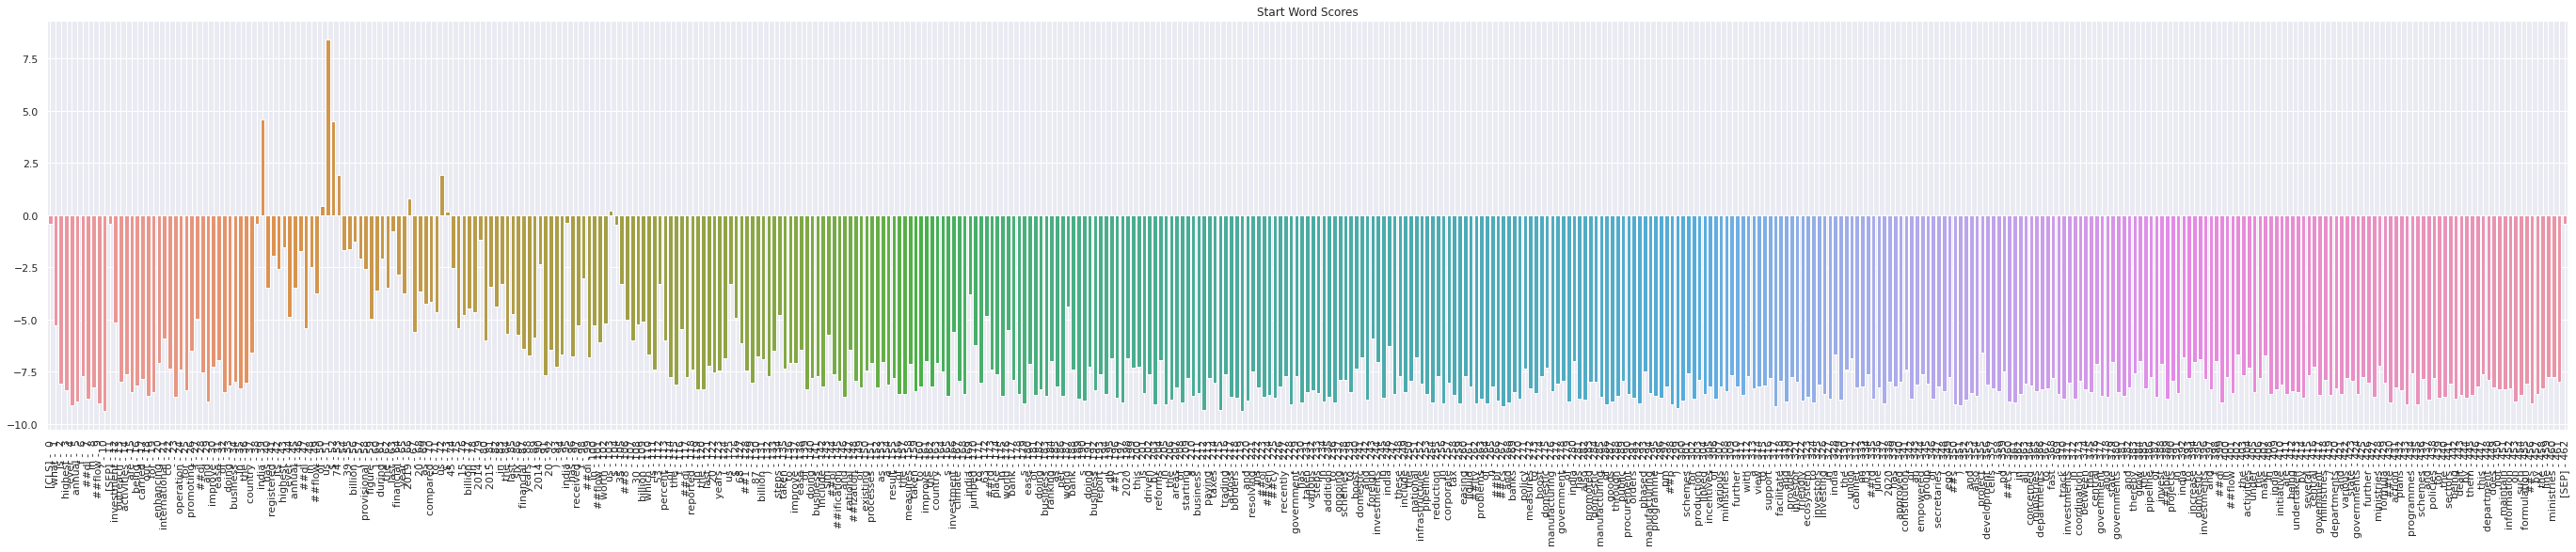

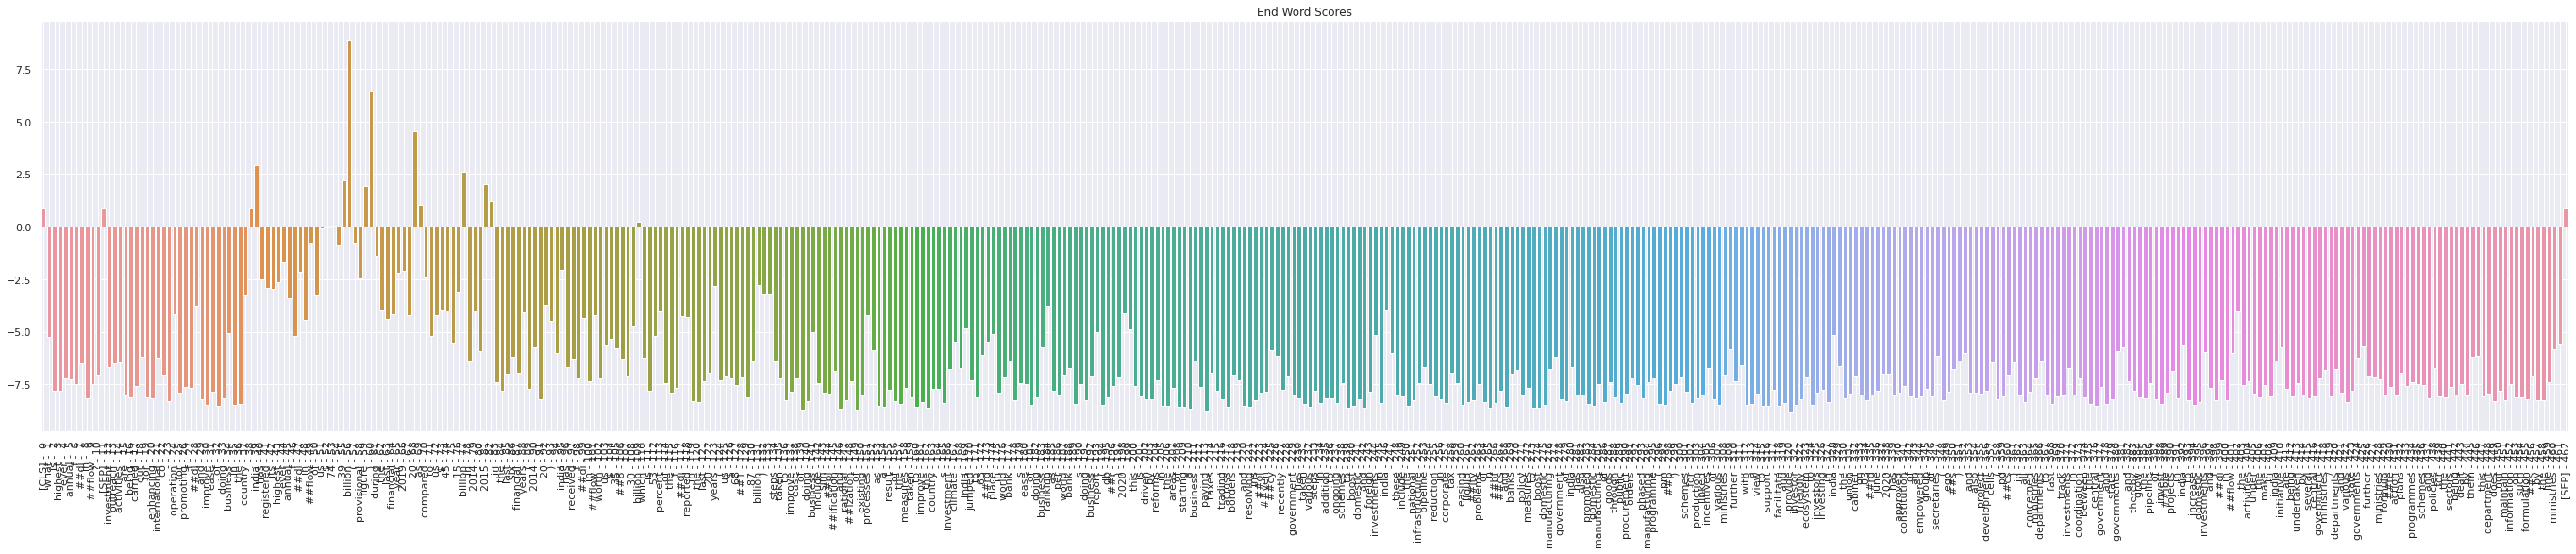

INFO:werkzeug:127.0.0.1 - - [20/Sep/2022 18:48:45] "POST / HTTP/1.1" 200 -


us $ 74 . 39 billion


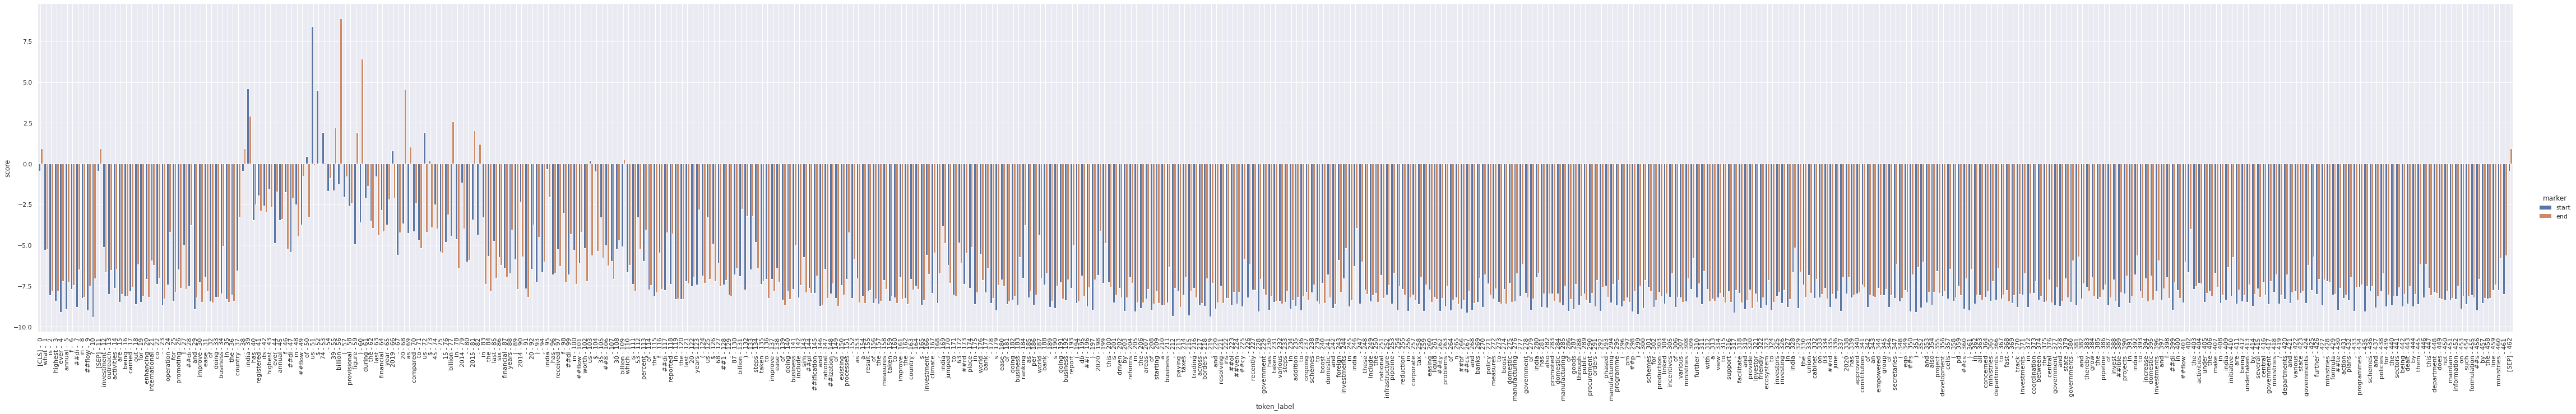

In [ ]:
app.run()